In [32]:
import json
import matplotlib.pyplot as plt
import numpy as np

import sys  
sys.path.insert(1, 'funcs')
import ScalarField
import TangentPoint
import TangentPointSet

In [33]:
f = open("tangentmaps/breast_cancer.tmap","r")
dataImport = json.loads(f.read())
tmap = dataImport['tmap']
Col_labels = dataImport['Col_labels']

data = dataImport

# print(data['tmap'][0])
# print(data['Col_labels'])

In [34]:
# First pass: Create Point instances with any initial scale_factor (e.g., 1.0)
points = []
for tmap_entry in tmap:
    point = TangentPoint.TangentPoint(tmap_entry, 1.0, Col_labels)
    points.append(point)

# Collect all gradient vectors and positions from the Point instances
all_positions = np.array([point.position for point in points if point.valid])  # Shape: (M, 2)
all_gradient_vectors = np.vstack([point.gradient_vectors for point in points if point.valid])  # Shape: (total_num_vectors, 2)

# Compute maximum gradient vector length
gradient_lengths = np.linalg.norm(all_gradient_vectors, axis=1)
max_gradient_length = np.max(gradient_lengths)

# Compute position ranges
x_range = np.max(all_positions[:, 0]) - np.min(all_positions[:, 0])
y_range = np.max(all_positions[:, 1]) - np.min(all_positions[:, 1])
position_range = max(x_range, y_range)

# Decide on desired fraction of position range for maximum gradient length
desired_fraction = 0.05  # Adjust as necessary

# Compute scale factor
scale_factor = (position_range * desired_fraction) / max_gradient_length
print("Computed scale factor:", scale_factor)

# Update scale factor in each Point instance
for point in points:
    if point.valid:
        point.update_scale_factor(scale_factor)

Computed scale factor: 0.6178953731105454


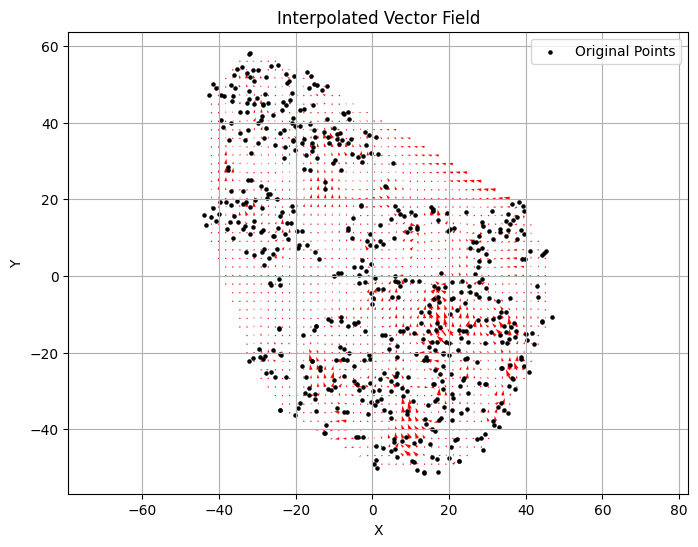

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

grad_index = 0
positions = []
vectors = []

# Collect positions and chosen gradient
for point in points:
    if point.valid and len(point.gradient_vectors) > grad_index:
        positions.append(point.position)
        vectors.append(point.gradient_vectors[grad_index])

positions = np.array(positions)  # shape: (N, 2)
vectors = np.array(vectors)      # shape: (N, 2)

# Define grid bounds and resolution
xmin, xmax = positions[:, 0].min(), positions[:, 0].max()
ymin, ymax = positions[:, 1].min(), positions[:, 1].max()
grid_res = 50

# Create mesh
grid_x, grid_y = np.mgrid[xmin:xmax:complex(grid_res), ymin:ymax:complex(grid_res)]

# Interpolate the U and V components onto the grid
grid_u = griddata(positions, vectors[:, 0], (grid_x, grid_y), method='linear')
grid_v = griddata(positions, vectors[:, 1], (grid_x, grid_y), method='linear')

# Plot vector field
plt.figure(figsize=(8, 6))
plt.quiver(grid_x, grid_y, grid_u, grid_v, angles='xy', scale_units='xy', scale=1.0, color='red')
plt.scatter(positions[:,0], positions[:,1], c='black', s=5, label='Original Points')
plt.title("Interpolated Vector Field")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

In [36]:
print(grid_y[0,:])
print(grid_x[:,0])

[-51.3103662  -49.07475288 -46.83913956 -44.60352623 -42.36791291
 -40.13229959 -37.89668627 -35.66107294 -33.42545962 -31.1898463
 -28.95423298 -26.71861965 -24.48300633 -22.24739301 -20.01177969
 -17.77616636 -15.54055304 -13.30493972 -11.0693264   -8.83371307
  -6.59809975  -4.36248643  -2.1268731    0.10874022   2.34435354
   4.57996686   6.81558019   9.05119351  11.28680683  13.52242015
  15.75803348  17.9936468   20.22926012  22.46487344  24.70048677
  26.93610009  29.17171341  31.40732673  33.64294006  35.87855338
  38.1141667   40.34978002  42.58539335  44.82100667  47.05661999
  49.29223331  51.52784664  53.76345996  55.99907328  58.2346866 ]
[-43.8341444  -41.98149648 -40.12884857 -38.27620065 -36.42355273
 -34.57090481 -32.71825689 -30.86560898 -29.01296106 -27.16031314
 -25.30766522 -23.4550173  -21.60236939 -19.74972147 -17.89707355
 -16.04442563 -14.19177771 -12.3391298  -10.48648188  -8.63383396
  -6.78118604  -4.92853812  -3.07589021  -1.22324229   0.62940563
   2.48205

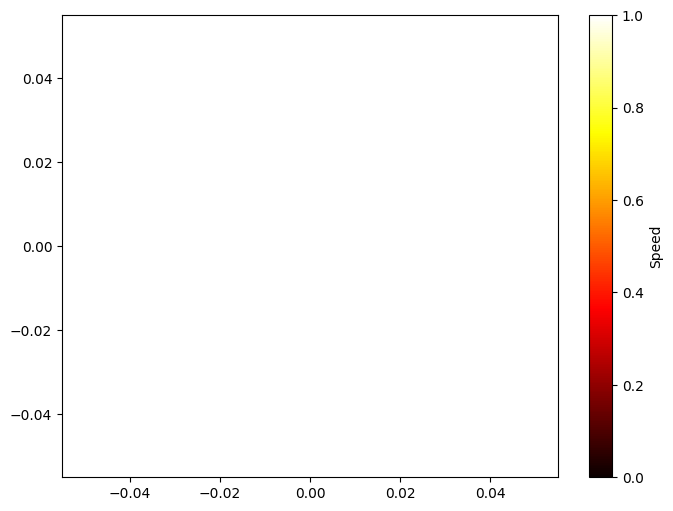

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.interpolate import RegularGridInterpolator

# Example 2D vector field on a regular grid (grid_x, grid_y).
# grid_u and grid_v should be 2D arrays of the same shape
# representing the vector field in X and Y directions, respectively.
# For instance, assume:
#   grid_x.shape = (ny, nx)
#   grid_y.shape = (ny, nx)
#   grid_u.shape = (ny, nx)
#   grid_v.shape = (ny, nx)
# and grid_x, grid_y give the mesh coordinates.

# Build interpolators for U and V using y first, then x:
interp_u = RegularGridInterpolator((grid_x[:,0], grid_y[0,:]), grid_u)
interp_v = RegularGridInterpolator((grid_x[:,0], grid_y[0,:]), grid_v)

# Number of particles
n_particles = 1000

# Place particles at random positions within the bounding box
x_min, x_max = grid_x.min(), grid_x.max()
y_min, y_max = grid_y.min(), grid_y.max()
particles = np.column_stack((
    np.random.uniform(x_min, x_max, n_particles),
    np.random.uniform(y_min, y_max, n_particles)
))

# Keep track of old positions for drawing short trails
old_positions = particles.copy()

# A small time step to move particles
dt = 0.05

fig, ax = plt.subplots(figsize=(8, 6))

# We’ll draw all particle trails as one collection of line segments.
lines = ax.scatter([], [], s=1, c=[], cmap='hot', vmin=0)

def init():
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('equal')
    ax.set_title("Particle-Based Flow Visualization")
    return (lines,)

def update(frame):
    global particles, old_positions
    
    # Interpolate wind vectors for each particle’s position
    u = interp_u(particles)
    v = interp_v(particles)
    
    # Compute new positions
    new_positions = particles + dt * np.column_stack((u, v))
    
    # Speeds for color intensity
    speeds = np.hypot(u, v)
    
    # Concatenate old->new line segments
    segments_x = np.array([old_positions[:,0], new_positions[:,0]]).T.ravel()
    segments_y = np.array([old_positions[:,1], new_positions[:,1]]).T.ravel()
    
    # Update scatter: draw all short segments
    lines.set_offsets(np.column_stack((segments_x, segments_y)))
    lines.set_array(np.repeat(speeds, 2))  # match array length
    lines.set_clim(vmin=0, vmax=speeds.max() or 1e-5)
    
    # Update old_positions and particles
    old_positions = new_positions.copy()
    particles = new_positions

    return (lines,)

anim = FuncAnimation(fig, update, init_func=init, frames=200, interval=50, blit=False)
plt.colorbar(lines, ax=ax, label="Speed")
plt.show()